In [1]:
import pandas as pd
import pdb
from pathlib import Path
from fastai.vision import *
from fastai.vision.gan import *
from sklearn.decomposition import PCA

In [104]:
functions = {"linear": lambda x,*params: params[1]*x + params[0],
             "quadratic": lambda x,*params: params[2]*x**2 + params[1]*x + params[0],
             "cubic": lambda x,*params: params[3]*x**3 + params[2]*x**2 + params[1]*x + params[0]}
#              "squareroot": lambda x,*params: params[0]*np.sqrt(x),
#              "log": lambda x,*params: params[0]*np.log(x + 1),
#              "exp": lambda x,*params: params[0]*np.exp(params[1]*x)}

In [147]:
simX = np.linspace(0,10,200)[None,:]
outT = []
outV = []
yT = []
yV = []
for i,(c,f) in enumerate(functions.items()):
    params = np.random.random((4,5000,1))
    outT.append(f(simX,*params[:,:4000]))
    outV.append(f(simX,*params[:,4000:]))
    yT += [i]*4000
    yV += [i]*1000
outT = np.concatenate(outT)
outV = np.concatenate(outV)

In [148]:
trainDS = torch.utils.data.TensorDataset(torch.tensor(outT,dtype=torch.float).unsqueeze(-1),torch.tensor(yT))
valDS = torch.utils.data.TensorDataset(torch.tensor(outV,dtype=torch.float).unsqueeze(-1),torch.tensor(yV))
trainDS.items = [1,2,3]
valDS.items = [1,2,3]
data = DataBunch.create(trainDS,valDS,num_workers=0)

In [149]:
class FClassifier(torch.nn.Module):
    def __init__(self,nClasses):
        super().__init__()
        self.rnn = torch.nn.LSTM(1,350,2,batch_first=True,dropout=0.5,bias=False)
        self.attn = torch.nn.Linear(350,1,bias=False)
        self.out = torch.nn.Linear(350,nClasses)
        
    def forward(self,ts):
        output,(h_n,c_n) = self.rnn(ts.float())
        a = torch.softmax(self.attn(output),dim=1)
        self.attns = a
        output = a * output
        output = output.sum(dim=1)
        return self.out(output)

In [150]:
model = FClassifier(len(functions))
learn = Learner(data,model,loss_func=torch.nn.functional.cross_entropy,metrics=[accuracy])
learn.split(split_model_idx(learn.model,idxs=[0,2]))

In [151]:
x,y = next(iter(data.train_dl))
learn.model(x).size()

torch.Size([64, 3])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


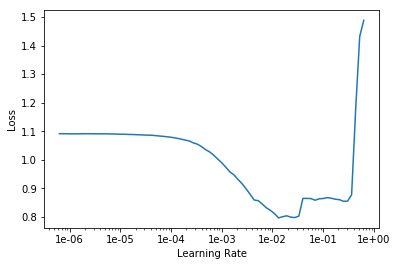

In [152]:
learn.lr_find()
learn.recorder.plot()

In [154]:
learn.fit_one_cycle(10,1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.105197,0.118383,0.969333
2,0.108220,0.117426,0.969667
3,0.097325,0.118077,0.969333
4,0.095435,0.116632,0.970333
5,0.099175,0.116032,0.970333
6,0.107164,0.115440,0.970000
7,0.101045,0.115520,0.970333
8,0.097783,0.115071,0.970333
9,0.106481,0.115182,0.970333
10,0.097944,0.115200,0.970333


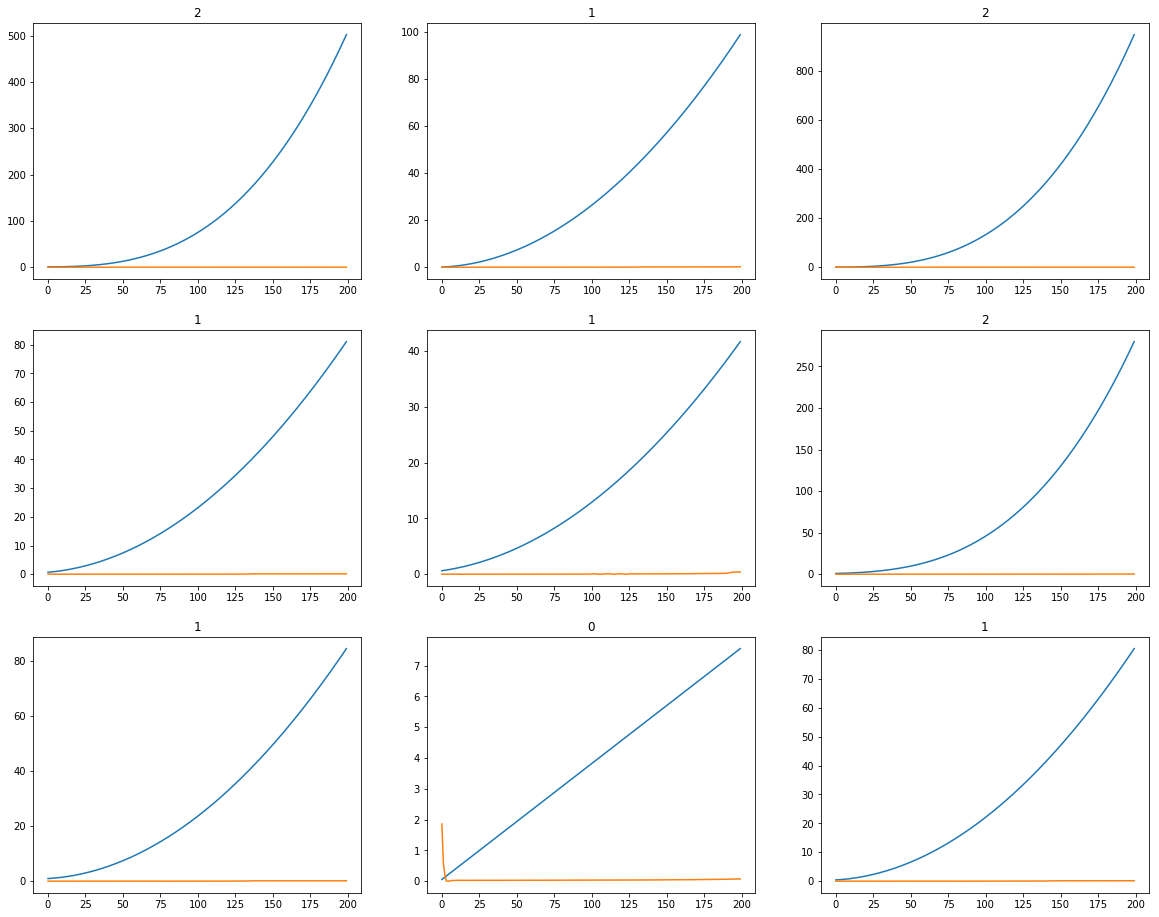

In [155]:
learn.model.eval()
preds = learn.model(x)
preds.size()
at = learn.model.attns
_,axes = plt.subplots(3,3,figsize=(20,16))
for ax, ts, p, a in zip(axes.flatten(),x,preds,at):
    ax.plot(ts.flatten())
    ax.plot(10*a.flatten())
    p = torch.argmax(p)
    ax.set_title(f"{p}")
    